## MT3DMS Problem 10

The purpose of this script is to (1) recreate the example problems that were first
described in the 1999 MT3DMS report, and (2) compare MF6-GWT solutions to the
established MT3DMS solutions.

Ten example problems appear in the 1999 MT3DMS manual, starting on page 130.
This notebook demonstrates example 10 from the list below:

  1. One-Dimensional Transport in a Uniform Flow Field
  2. One-Dimensional Transport with Nonlinear or Nonequilibrium Sorption
  3. Two-Dimensional Transport in a Uniform Flow Field
  4. Two-Dimensional Transport in a Diagonal Flow Field
  5. Two-Dimensional Transport in a Radial Flow Field
  6. Concentration at an Injection/Extraction Well
  7. Three-Dimensional Transport in a Uniform Flow Field
  8. Two-Dimensional, Vertical Transport in a Heterogeneous Aquifer
  9. Two-Dimensional Application Example
  10. _Three-Dimensional Field Case Study_

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from flopy.utils.util_array import read1d
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwt-mt3dms-p10"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = pl.Path(f"../data/{sim_name}")
data_path = data_path if data_path.is_dir() else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "feet"
time_units = "days"

# Model parameters
nlay = 4  # Number of layers
nrow = 61  # Number of rows
ncol = 40  # Number of columns
delr = "varies"  # Column width ($ft$)
delc = "varies"  # Row width ($ft$)
delz = 25.0  # Layer thickness ($ft$)
top = 780.0  # Top of the model ($ft$)
satthk = 100.0  # Saturated thickness ($ft$)
k1 = 60.0  # Horiz. hyd. conductivity of layers 1 and 2 ($ft/day$)
k2 = 520.0  # Horiz. hyd. conductivity of layers 3 and 4 ($ft/day$)
vka = 0.1  # Ratio of vertical to horizontal hydraulic conductivity
rech = 5.0  # Recharge rate ($in/yr$)
crech = 0.0  # Concentration of recharge ($ppm$)
prsity = 0.3  # Porosity
al = 10.0  # Longitudinal dispersivity ($ft$)
trpt = 0.2  # Ratio of horizontal transverse dispersivity to longitudinal dispersivity
trpv = 0.2  # Ratio of vertical transverse dispersivity to longitudinal dispersivity
rhob = 1.7  # Aquifer bulk density ($g/cm^3$)
sp1 = 0.176  # Distribution coefficient ($cm^3/g$)
perlen = 1000.0  # Simulation time ($days$)

# Additional model input
delr = [2000, 1600, 800, 400, 200, 100] + 28 * [50] + [100, 200, 400, 800, 1600, 2000]
delc = (
    [2000, 2000, 2000, 1600, 800, 400, 200, 100]
    + 45 * [50]
    + [100, 200, 400, 800, 1600, 2000, 2000, 2000]
)
hk = [60.0, 60.0, 520.0, 520.0]
laytyp = icelltype = 0
# Starting Heads:
fname = "p10shead.dat"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:c6591c3c3cfd023ab930b7b1121bfccf",
)
f = open(fpath)
s0 = np.empty((nrow * ncol), dtype=float)
s0 = read1d(f, s0).reshape((nrow, ncol))
f.close()
strt = np.zeros((nlay, nrow, ncol), dtype=float)
for k in range(nlay):
    strt[k] = s0
# Active model domain
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound[:, :, 0] = -1  # left side
ibound[:, :, -1] = -1  # right side
ibound[:, 0, :] = -1  # top
ibound[:, -1, :] = -1  # bottom
icbund = idomain = 1

# Boundary conditions
rech = 12.7 / 365 / 30.48  # cm/yr -> ft/day
crch = 0.0
# MF2K5 pumping info
welspd_Q = [
    [3 - 1, 11 - 1, 29 - 1, -19230.00],
    [3 - 1, 19 - 1, 26 - 1, -19230.00],
    [3 - 1, 26 - 1, 23 - 1, -19230.00],
    [3 - 1, 33 - 1, 20 - 1, -19230.00],
    [3 - 1, 40 - 1, 17 - 1, -19230.00],
    [3 - 1, 48 - 1, 14 - 1, -19230.00],
    [3 - 1, 48 - 1, 9 - 1, -15384.00],
    [3 - 1, 52 - 1, 17 - 1, -17307.00],
]
#                  k,      i,      j,   Q, itype
welspd_ssm = [
    [3 - 1, 11 - 1, 29 - 1, 0.0, 2],
    [3 - 1, 19 - 1, 26 - 1, 0.0, 2],
    [3 - 1, 26 - 1, 23 - 1, 0.0, 2],
    [3 - 1, 33 - 1, 20 - 1, 0.0, 2],
    [3 - 1, 40 - 1, 17 - 1, 0.0, 2],
    [3 - 1, 48 - 1, 14 - 1, 0.0, 2],
    [3 - 1, 48 - 1, 9 - 1, 0.0, 2],
    [3 - 1, 52 - 1, 17 - 1, 0.0, 2],
]
# MF6 pumping information
welspd_mf6 = []
#                 [(layer,    row, column),     flow, conc]
welspd_mf6.append([(3 - 1, 11 - 1, 29 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 19 - 1, 26 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 26 - 1, 23 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 33 - 1, 20 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 40 - 1, 17 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 48 - 1, 14 - 1), -19230.0, 0.00])
welspd_mf6.append([(3 - 1, 48 - 1, 9 - 1), -15384.0, 0.00])
welspd_mf6.append([(3 - 1, 52 - 1, 17 - 1), -17307.0, 0.00])
wel_mf6_spd = {0: welspd_mf6}

# Transport related
# Starting concentrations:
fname = "p10cinit.dat"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:8e2d3ba7af1ec65bb07f6039d1dfb2c8",
)
f = open(fpath)
c0 = np.empty((nrow * ncol), dtype=float)
c0 = read1d(f, c0).reshape((nrow, ncol))
f.close()
sconc = np.zeros((nlay, nrow, ncol), dtype=float)
sconc[1] = 0.2 * c0
sconc[2] = c0
# Dispersion
ath1 = al * trpt
atv = al * trpv
dmcoef = 0.0  # ft^2/day
# Time variables
perlen = 1000.0
nstp = 100
ttsmult = 1.0
#
c0 = 0.0
botm = [top - delz * k for k in range(1, nlay + 1)]
mixelm = 0
# Reactive transport related terms
isothm = 1  # sorption type; 1=linear isotherm (equilibrium controlled)
sp2 = 0.0  # w/ isothm = 1 this is read but not used
# ***Note:  In the original documentation for this problem, the following two
#           values are specified in units of g/cm^3 and cm^3/g, respectively.
#           All other units in this problem appear to use ft, including the
#           grid discretization, aquifer K (ft/day), recharge (ft/yr),
#           pumping (ft^3/day), & dispersion (ft).  Because this problem
#           attempts to recreate the original problem for comparison purposes,
#           we are sticking with these values while also acknowledging this
#           discrepancy.
rhob = 1.7  # g/cm^3
sp1 = 0.176  # cm^3/g  (Kd: "Distribution coefficient")
# Transport observations
# Instantiate the basic transport package
obs = [
    [3 - 1, 11 - 1, 29 - 1],
    [3 - 1, 19 - 1, 26 - 1],
    [3 - 1, 26 - 1, 23 - 1],
    [3 - 1, 33 - 1, 20 - 1],
    [3 - 1, 40 - 1, 17 - 1],
    [3 - 1, 48 - 1, 14 - 1],
    [3 - 1, 48 - 1, 9 - 1],
    [3 - 1, 52 - 1, 17 - 1],
]

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
percel = 1.0  # HMOC parameters
itrack = 2
wd = 0.5
dceps = 1.0e-5
nplane = 0
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph
nadvfd = 1

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(mixelm=0, silent=False):
    print(f"Building mf2005 model...{sim_name}")
    mt3d_ws = os.path.join(workspace, sim_name, "mt3d")
    modelname_mf = "p10-mf"

    # Instantiate the MODFLOW model
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=mt3d_ws, exe_name="mf2005"
    )

    # Instantiate discretization package
    # units: itmuni=4 (days), lenuni=2 (m)
    flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        perlen=perlen,
        nstp=nstp,
        itmuni=4,
        lenuni=1,
    )

    # Instantiate basic package
    flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

    # Instantiate layer property flow package
    flopy.modflow.ModflowLpf(mf, hk=hk, layvka=1, vka=vka, laytyp=laytyp)

    # Instantiate recharge package
    flopy.modflow.ModflowRch(mf, rech=rech)

    # Instantiate well package
    flopy.modflow.ModflowWel(mf, stress_period_data=welspd_Q)

    # Instantiate solver package
    flopy.modflow.ModflowPcg(mf)

    # Instantiate link mass transport package (for writing linker file)
    flopy.modflow.ModflowLmt(mf)

    # Instantiate output control (OC) package
    spd = {
        (0, 0): ["save head"],
        (0, 49): ["save head"],
        (0, 74): ["save head"],
        (0, 99): ["save head"],
    }
    oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd)

    # Transport
    print(f"Building mt3d-usgs model...{sim_name}")

    modelname_mt = "p10-mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=mt3d_ws,
        exe_name="mt3dusgs",
        modflowmodel=mf,
    )

    # Instantiate basic transport package
    flopy.mt3d.Mt3dBtn(
        mt,
        icbund=icbund,
        prsity=prsity,
        sconc=sconc,
        perlen=perlen,
        dt0=2.0,
        ttsmult=ttsmult,
        timprs=[10, 500, 750, 1000],
        obs=obs,
    )

    # Instatiate the advection package
    flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=percel,
    )

    # Instantiate the dispersion package
    flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef)

    # Instantiate the source/sink mixing package
    ssmspd = {0: welspd_ssm}
    flopy.mt3d.Mt3dSsm(mt, crch=crch, stress_period_data=ssmspd)

    # Instantiate the recharge package
    flopy.mt3d.Mt3dRct(mt, isothm=isothm, igetsc=0, rhob=rhob, sp1=sp1, sp2=sp2)

    # Instantiate the GCG solver in MT3DMS
    flopy.mt3d.Mt3dGcg(mt)

    # MODFLOW 6
    print(f"Building mf6gwt model...{sim_name}")

    name = "p10-mf6"
    gwfname = "gwf-" + name
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating MODFLOW 6 time discretization
    tdis_rc = []
    tdis_rc.append((perlen, 500, 1.0))
    flopy.mf6.ModflowTdis(sim, nper=1, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwfname}.dis",
    )

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        k33overk=True,
        icelltype=laytyp,
        k=hk,
        k33=vka,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )

    # Instantiate storage package
    flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{gwfname}.sto")

    # Instantiating MODFLOW 6 constant head package
    # MF6 constant head boundaries:
    chdspd = []
    # Loop through the left & right sides for all layers.
    for k in np.arange(nlay):
        for i in np.arange(nrow):
            #              (l, r,      c),               head, conc
            chdspd.append([(k, i, 0), strt[k, i, 0], 0.0])  # left
            chdspd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 0.0])  # right

        for j in np.arange(1, ncol - 1):  # skip corners, already added above
            #              (l,      r, c),               head, conc
            chdspd.append([(k, 0, j), strt[k, 0, j], 0.0])  # top
            chdspd.append([(k, nrow - 1, j), strt[k, nrow - 1, j], 0.0])  # bottom

    chdspd = {0: chdspd}

    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="CHD-1",
        filename=f"{gwfname}.chd",
    )

    # Instantiate recharge package
    flopy.mf6.ModflowGwfrcha(
        gwf,
        print_flows=True,
        recharge=rech,
        pname="RCH-1",
        filename=f"{gwfname}.rch",
    )

    # Instantiate the wel package
    flopy.mf6.ModflowGwfwel(
        gwf,
        print_input=True,
        print_flows=True,
        stress_period_data=wel_mf6_spd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="WEL-1",
        filename=f"{gwfname}.wel",
    )

    # Instantiating MODFLOW 6 output control package for flow model
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.bud",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[
            ("HEAD", "LAST"),
            ("HEAD", "STEPS", "1", "250", "375", "500"),
            ("BUDGET", "LAST"),
        ],
        printrecord=[
            ("HEAD", "LAST"),
            ("BUDGET", "FIRST"),
            ("BUDGET", "LAST"),
        ],
    )

    # Instantiating MODFLOW 6 groundwater transport package
    gwtname = "gwt-" + name
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=gwtname,
        model_nam_file=f"{gwtname}.nam",
    )
    gwt.name_file.save_flows = True

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwtname}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # Instantiating MODFLOW 6 transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwtname}.dis",
    )

    # Instantiating MODFLOW 6 transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")

    # Instantiating MODFLOW 6 transport advection package
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")

    # Instantiating MODFLOW 6 transport dispersion package
    if al != 0:
        flopy.mf6.ModflowGwtdsp(
            gwt,
            alh=al,
            ath1=ath1,
            atv=atv,
            pname="DSP-1",
            filename=f"{gwtname}.dsp",
        )

    # Instantiating MODFLOW 6 transport mass storage package
    Kd = sp1
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=prsity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption="linear",
        bulk_density=rhob,
        distcoef=Kd,
        pname="MST-1",
        filename=f"{gwtname}.mst",
    )

    # Instantiating MODFLOW 6 transport source-sink mixing package
    sourcerecarray = [("CHD-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(
        gwt,
        sources=sourcerecarray,
        print_flows=True,
        filename=f"{gwtname}.ssm",
    )

    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwtname}.cbc",
        concentration_filerecord=f"{gwtname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[
            ("CONCENTRATION", "LAST"),
            ("CONCENTRATION", "STEPS", "1", "250", "375", "500"),
            ("BUDGET", "LAST"),
        ],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        filename=f"{gwtname}.oc",
    )

    # Instantiating MODFLOW 6 flow-transport exchange mechanism
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename=f"{name}.gwfgwt",
    )
    return mf, mt, sim


def write_models(mf2k5, mt3d, sim, silent=True):
    mf2k5.write_input()
    mt3d.write_input()
    sim.write_simulation(silent=silent)


@timed
def run_models(mf2k5, mt3d, sim, silent=True):
    success, buff = mf2k5.run_model(silent=silent, report=True)
    # assert success, pformat(buff)  # expect convergence failure
    success, buff = mt3d.run_model(
        silent=silent, report=True, normal_msg="Program completed"
    )
    assert success, pformat(buff)
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 8)


def plot_results(mf2k5, mt3d, mf6, idx, ax=None):
    mt3d_out_path = mt3d.model_ws
    mf6.simulation_data.mfpath.get_sim_path()

    # Get the MT3DMS concentration output
    fname_mt3d = os.path.join(mt3d_out_path, "MT3D001.UCN")
    ucnobj_mt3d = flopy.utils.UcnFile(fname_mt3d)
    conc_mt3d = ucnobj_mt3d.get_alldata()

    # Get the MF6 concentration output
    gwt = mf6.get_model(list(mf6.model_names)[1])
    ucnobj_mf6 = gwt.output.concentration()
    conc_mf6 = ucnobj_mf6.get_alldata()

    # Create figure for scenario
    with styles.USGSPlot():
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]

        xc, yc = mf2k5.modelgrid.xycenters
        levels = np.arange(0.2, 10, 0.4)
        stp_idx = 0  # 0-based (out of 2 possible stress periods)

        cinit = mt3d.btn.sconc[0].array[2]
        # Plots of concentration
        axWasNone = False
        if ax is None:
            fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
            ax = fig.add_subplot(2, 2, 1, aspect="equal")
            axWasNone = True

        mm = flopy.plot.PlotMapView(model=mf2k5)
        mm.plot_grid(color=".5", alpha=0.2)
        cs = mm.contour_array(cinit, levels=np.arange(20, 200, 20))
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        plt.clabel(cs, fmt=r"%3d")
        for k, i, j, q in mf2k5.wel.stress_period_data[0]:
            plt.plot(xc[j], yc[i], "ks")

        title = "Layer 3 Initial Concentration"
        letter = chr(ord("@") + idx + 1)
        styles.heading(letter=letter, heading=title)

        # 2nd figure
        if axWasNone:
            ax = fig.add_subplot(2, 2, 2, aspect="equal")

        c = conc_mt3d[1, 2]  # Layer 3 @ 500 days (2nd specified output time)
        mm = flopy.plot.PlotMapView(model=mf2k5)
        mm.plot_grid(color=".5", alpha=0.2)
        cs1 = mm.contour_array(c, levels=np.arange(10, 200, 10), colors="black")
        plt.clabel(cs1, fmt=r"%3d")
        c_mf6 = conc_mf6[1, 2]  # Layer 3 @ 500 days
        cs2 = mm.contour_array(
            c_mf6, levels=np.arange(10, 200, 10), colors="red", linestyles="--"
        )
        labels = ["MT3DMS", "MODFLOW 6"]
        lines = [cs1.collections[0], cs2.collections[0]]
        ax.legend(lines, labels, loc="upper left")

        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")

        for k, i, j, q in mf2k5.wel.stress_period_data[0]:
            plt.plot(xc[j], yc[i], "ks")

        title = "MT3D Layer 3 Time = 500 days"
        letter = chr(ord("@") + idx + 2)
        styles.heading(letter=letter, heading=title)

        # 3rd figure
        if axWasNone:
            ax = fig.add_subplot(2, 2, 3, aspect="equal")
        c = conc_mt3d[2, 2]
        mm = flopy.plot.PlotMapView(model=mf2k5)
        mm.plot_grid(color=".5", alpha=0.2)
        cs1 = mm.contour_array(c, levels=np.arange(10, 200, 10), colors="black")
        plt.clabel(cs1, fmt=r"%3d")
        c_mf6 = conc_mf6[2, 2]
        cs2 = mm.contour_array(
            c_mf6, levels=np.arange(10, 200, 10), colors="red", linestyles="--"
        )
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        for k, i, j, q in mf2k5.wel.stress_period_data[0]:
            plt.plot(xc[j], yc[i], "ks")

        title = "MT3D Layer 3 Time = 750 days"
        letter = chr(ord("@") + idx + 3)
        styles.heading(letter=letter, heading=title)

        # 4th figure
        if axWasNone:
            ax = fig.add_subplot(2, 2, 4, aspect="equal")
        c = conc_mt3d[3, 2]
        mm = flopy.plot.PlotMapView(model=mf2k5)
        mm.plot_grid(color=".5", alpha=0.2)
        cs1 = mm.contour_array(c, levels=np.arange(10, 200, 10), colors="black")
        plt.clabel(cs1, fmt=r"%3d")
        c_mf6 = conc_mf6[3, 2]
        cs2 = mm.contour_array(
            c_mf6, levels=np.arange(10, 200, 10), colors="red", linestyles="--"
        )
        plt.xlim(5100, 5100 + 28 * 50)
        plt.ylim(9100, 9100 + 45 * 50)
        plt.xlabel("Distance Along X-Axis, in meters")
        plt.ylabel("Distance Along Y-Axis, in meters")
        for k, i, j, q in mf2k5.wel.stress_period_data[0]:
            plt.plot(xc[j], yc[i], "ks")

        title = "MT3D Layer 3 Time = 1,000 days"
        letter = chr(ord("@") + idx + 4)
        styles.heading(letter=letter, heading=title)

        plt.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / "{}{}".format(
                mf6.name,
                ".png",
            )
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx, silent=True):
    mf2k5, mt3d, sim = build_models(mixelm=mixelm)
    if write:
        write_models(mf2k5, mt3d, sim, silent=silent)
    if run:
        run_models(mf2k5, mt3d, sim, silent=silent)
    if plot:
        plot_results(mf2k5, mt3d, sim, idx)

Compares the standard finite difference solutions between MT3D and MF6.

Building mf2005 model...ex-gwt-mt3dms-p10
Building mt3d-usgs model...ex-gwt-mt3dms-p10
Building mf6gwt model...ex-gwt-mt3dms-p10


run_models took 56165.00 ms


/tmp/ipykernel_7761/3411027593.py:64: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  lines = [cs1.collections[0], cs2.collections[0]]
/tmp/ipykernel_7761/3411027593.py:64: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  lines = [cs1.collections[0], cs2.collections[0]]


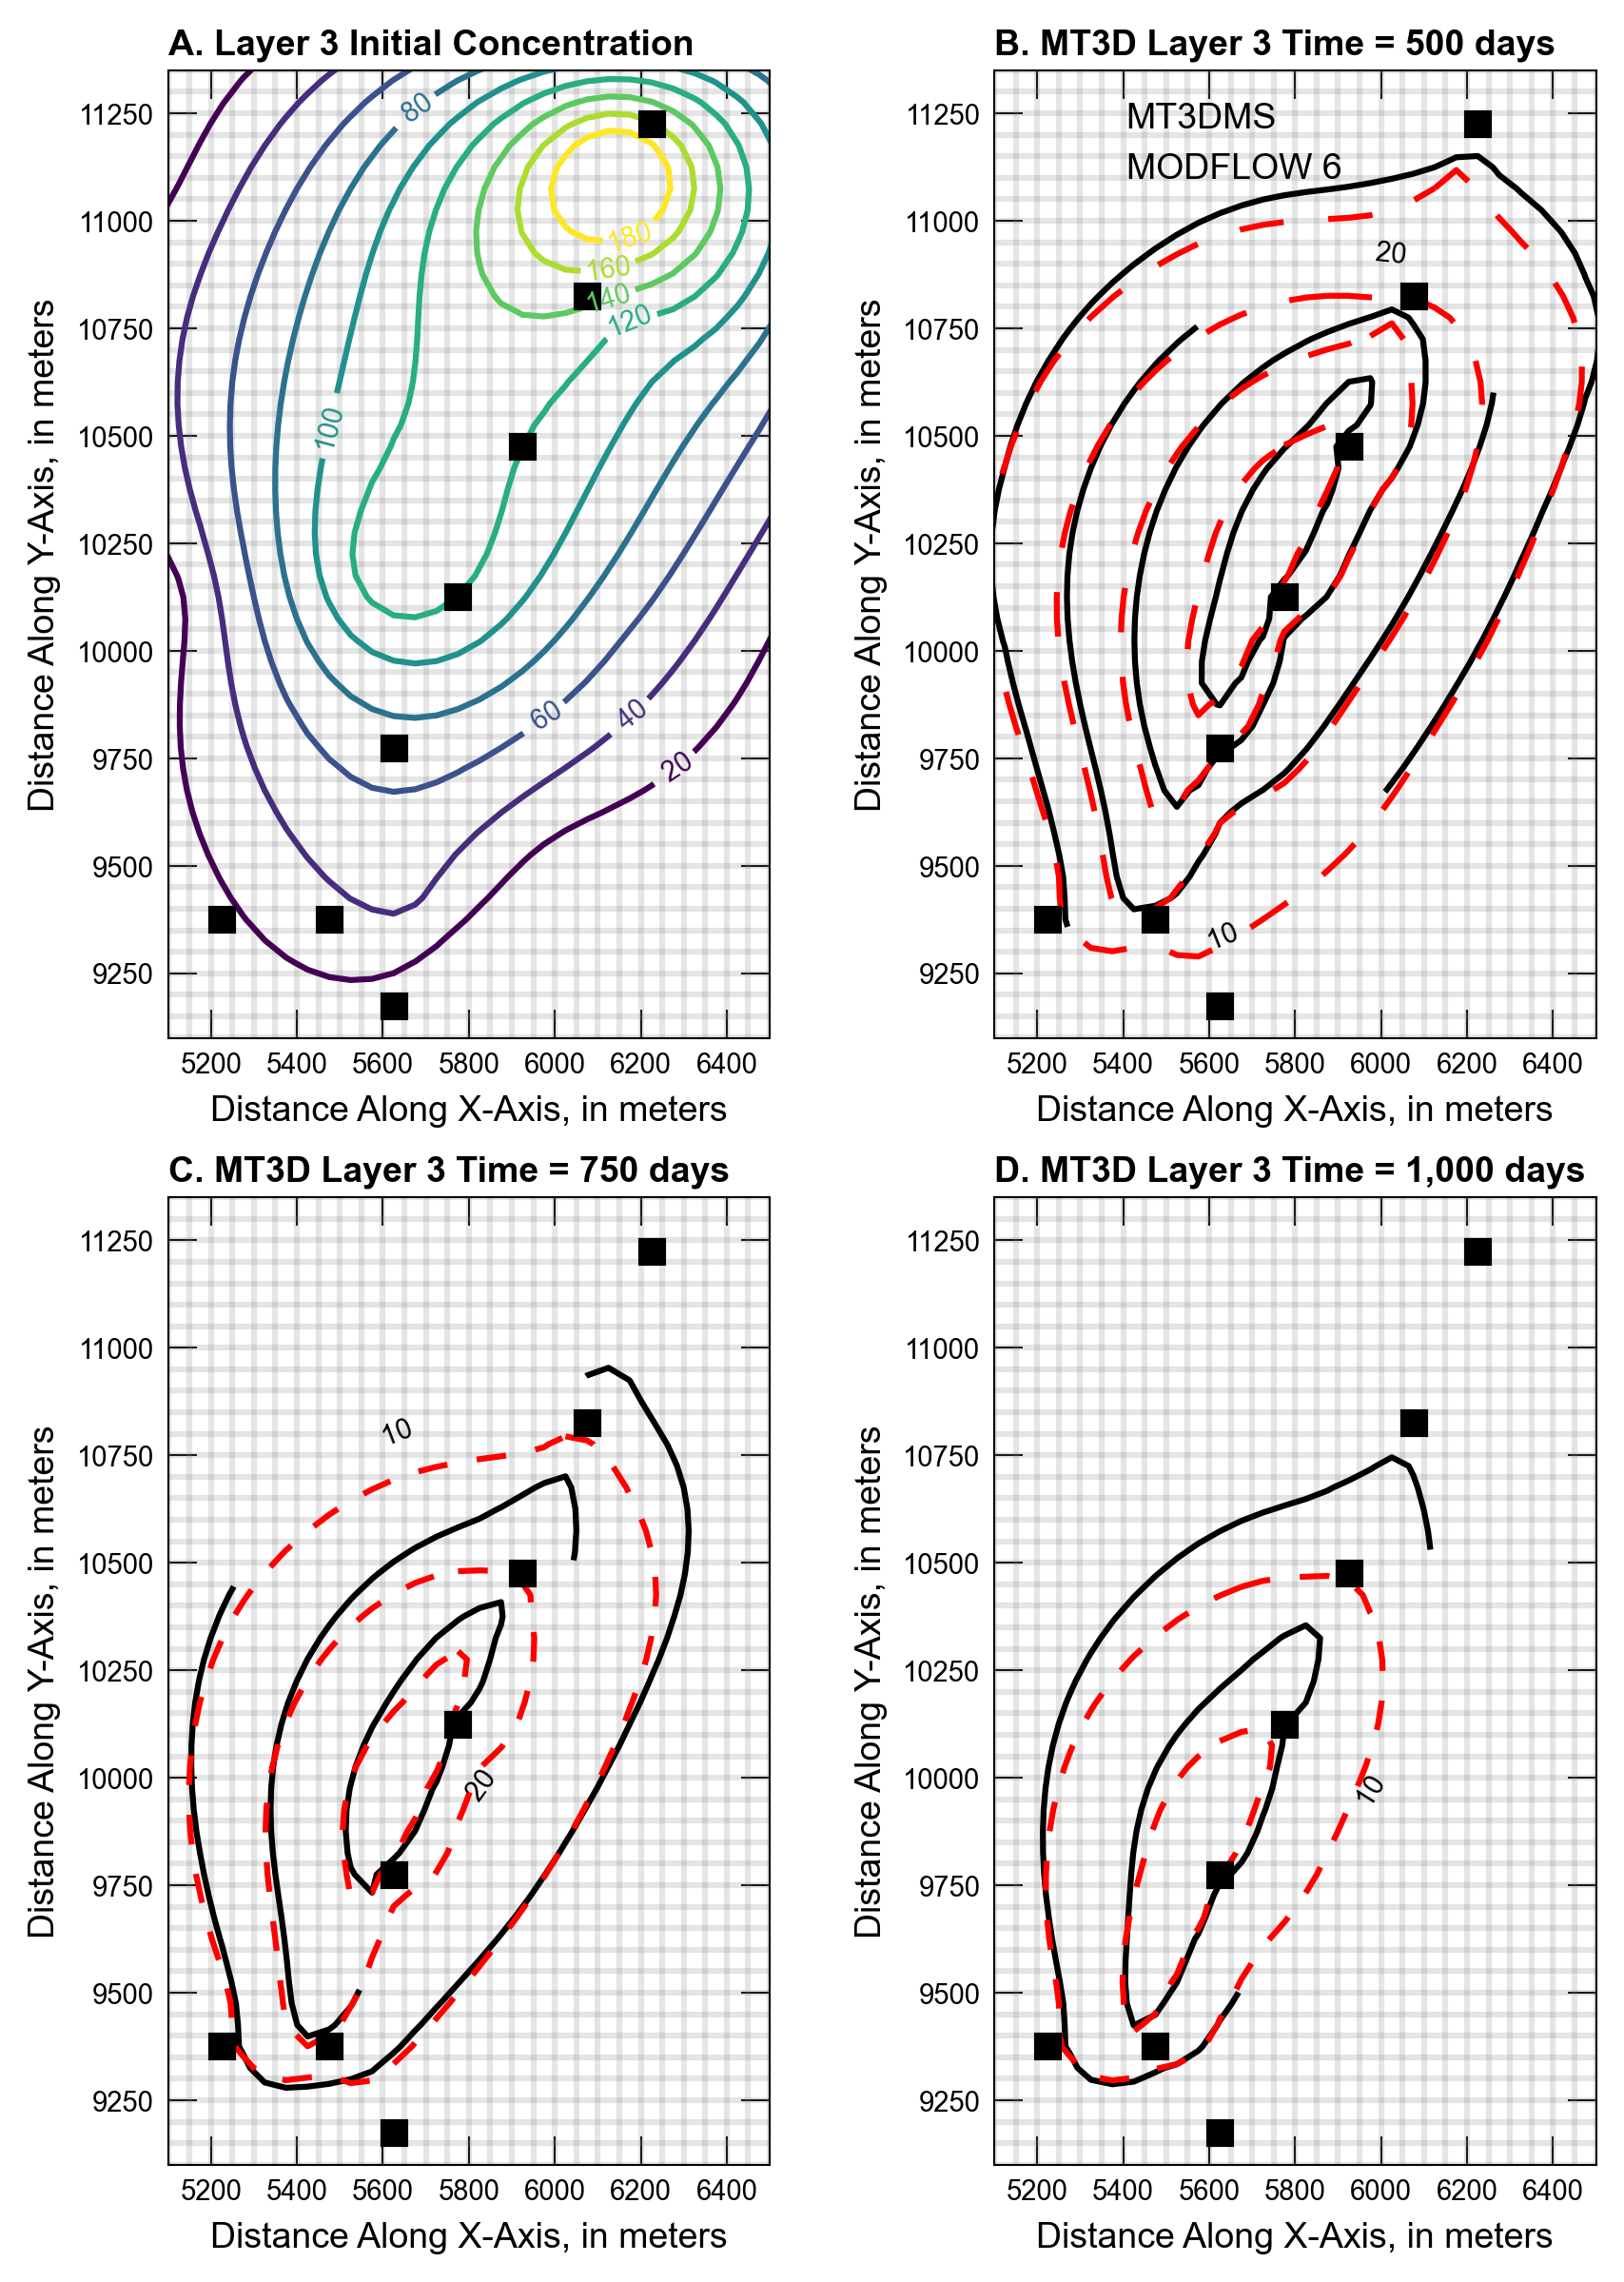

In [6]:
scenario(0)